In [1]:
import pickle
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt


from modules.calibration import draw_keypoints_and_match, drawlines, RANSAC_F_mat, compute_Essential_matrix
from old.rectification import rectification
from modules.correspondence import ssd_correspondence
from modules.depth import disparity_to_depth
from modules import draw_show_img_utils as dsiu
from datasets.load_dataset import Data

array([[31.811295, 31.734158, 31.734566, ..., 50.78351 , 50.825806,
        50.891296],
       [31.70718 , 31.58937 , 31.588165, ..., 50.773865, 50.807007,
        50.859924],
       [31.582508, 31.593327, 31.502758, ..., 50.758118, 50.80365 ,
        50.90674 ],
       ...,
       [29.00631 , 28.962505, 28.907917, ..., 37.775818, 37.829224,
        37.8808  ],
       [29.06543 , 29.016228, 28.963715, ..., 37.919434, 37.972717,
        38.022217],
       [29.097538, 29.043945, 28.98737 , ..., 38.060364, 38.11432 ,
        38.165222]], dtype=float32)

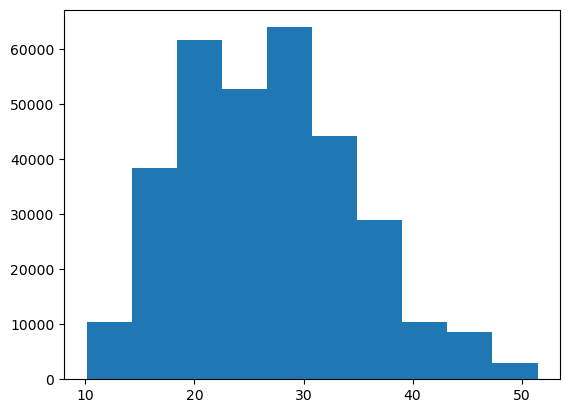

In [18]:
def read_pfm(path):
    with open(path, 'rb') as f:
        header = f.readline().decode().strip()
        if header == 'PF':
            color = True
        elif header == 'Pf':
            color = False
        else:
            raise Exception('Not a PFM file.')

        dimensions = f.readline().decode().strip()
        width, height = map(int, dimensions.split())
        scale = float(f.readline().decode().strip())
        if scale < 0:  # little-endian
            endian = '<'
            scale = -scale
        else:
            endian = '>'

        data = np.fromfile(f, endian + 'f')
        shape = (height, width, 3) if color else (height, width)

        return np.reshape(data, shape), scale
    

a, s = read_pfm(r"D:\code\py_steoreo_depth_estimation\datasets\disp3GT.pfm")

plt.hist(a[a<float("inf")])
a

In [22]:
cv2.imread(r"D:\code\py_steoreo_depth_estimation\datasets\disp2GT.pfm", cv2.IMREAD_UNCHANGED)

array([[ 2897.4824,  2894.6238,  2881.2043, ...,  6601.57  ,  6592.6685,
               inf],
       [ 2893.8242,  2892.3606,  2881.2676, ...,  6596.372 ,        inf,
               inf],
       [ 2888.4856,  2887.6772,  2879.4585, ...,        inf,        inf,
               inf],
       ...,
       [15086.39  , 15085.626 , 15084.892 , ..., 14975.1045, 14971.992 ,
        14973.642 ],
       [15129.865 , 15129.626 , 15128.794 , ..., 15018.368 , 15019.52  ,
        15021.761 ],
       [15172.396 , 15172.55  , 15172.749 , ..., 15069.101 , 15070.097 ,
        15069.708 ]], dtype=float32)

In [ ]:
def l2(x, y, eval_func=np.average):
    return eval_func((x-y)**2)

In [ ]:
f_diff = list()
d_diff = list()
displ_n = list()
dispr_n = list()

# # block size 


for i in range(2,6):
    data = Data(i)
    print(i)
    img1 = data.img1
    img2 = data.img2
    list_kp1, list_kp2, matched_image = draw_keypoints_and_match(img1, img2)
    F = RANSAC_F_mat(list_kp1, list_kp2)
    K1 = data.calib["cam0"]
    K2 = data.calib["cam1"]
    E = compute_Essential_matrix(F, K1, K2)
    pts1 = np.asarray(list_kp1, dtype=np.float32)
    pts2 = np.asarray(list_kp2, dtype=np.float32)
    
    f_diff.append(l2(F, cv2.findFundamentalMat(list_kp1, list_kp2)[0]))
    

    # left corresspondence
    _, disparity_map_scaled = ssd_correspondence(
        img1, img2, 15) # right disparity as refernces
    
    img_n = cv2.normalize(src=disparity_map_scaled, dst=None, alpha=0,
                        beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    d_diff.append(l2(img_n, data.GTruth))
    
    displ_n.append(img_n)
    
    # right corresspondence
    _, disparity_map_scaled = ssd_correspondence(img2, img1, 15)  # right disparity as refernces

    img_n = cv2.normalize(src=disparity_map_scaled, dst=None, alpha=0,
                          beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    dispr_n.append(img_n)


# with open(os.path.join("gallery", "displ_n15"), "wb") as file:
#     pickle.dump(displ_n, file)

# with open(os.path.join("gallery", "dispr_n15"), "wb") as file:
#     pickle.dump(dispr_n, file)

In [ ]:
# print(f_diff)
# print(d_diff)

# with open(os.path.join("gallery", "disp_n15"), "wb") as path:
#     pickle.dump(displ_n, path)

[0.12096126508598627, 0.11089916541357171, 0.008062249241351668, 0.025290632919402166]
[73.09545803837872, 100.12760132562113, 84.08022722491059, 90.90225777777778]


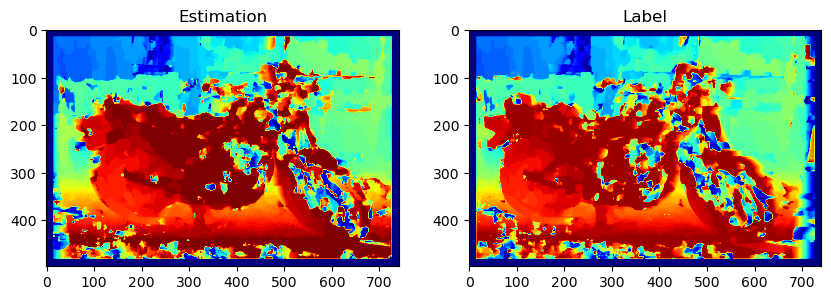

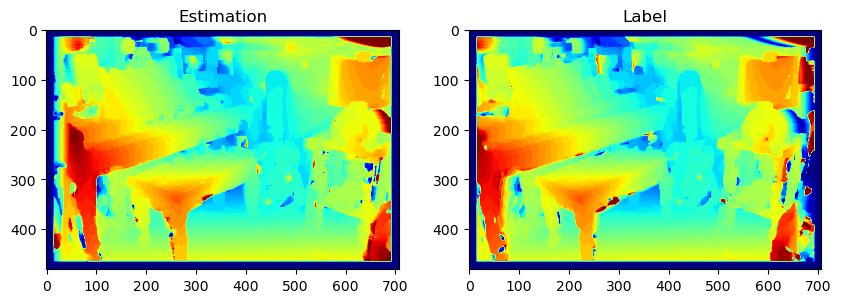

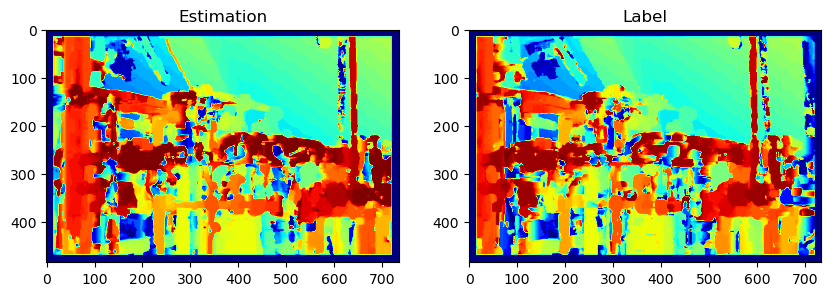

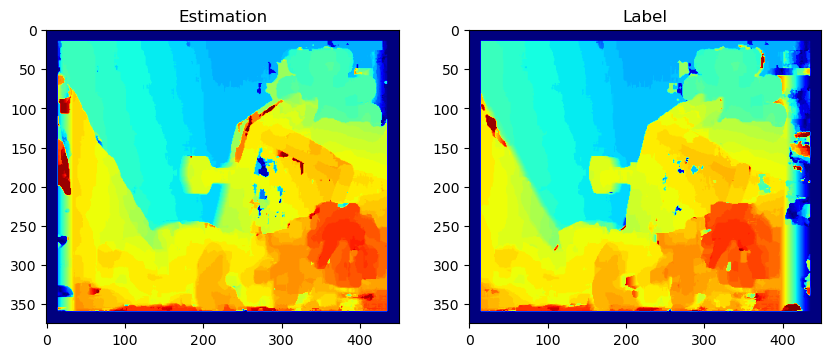

In [ ]:
for i in range(4):
    dsiu.draw_2_img(displ_n[i], dispr_n[i], "Estimation", "Label", cmap="jet")

## Compare with SGM

In [ ]:
sgm_disp = list()

for i in range(2,6):
    data = Data(i)

    # Create StereoSGBM object
    window_size = 5
    min_disp = -1
    num_disp = 16 * 4  # Must be divisible by 16

    stereo = cv2.StereoSGBM.create(
        minDisparity=0,
        numDisparities=num_disp,
        blockSize=window_size,
        P1=8 * 3 * window_size ** 2,
        P2=32 * 3 * window_size ** 2,
        disp12MaxDiff=1,
        uniquenessRatio=15,
        speckleWindowSize=50,
        speckleRange=2,
        preFilterCap=63,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )

    # Compute disparity map
    disparity = stereo.compute(data.img1, data.img2) # .astype(np.float32) / 16.0

    # Normalize and display the disparity map
    disparity = cv2.normalize(disparity, None, alpha=0,
                            beta=255, norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    
    wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=stereo)
    wls_filter.setLambda(80000)
    wls_filter.setSigmaColor(1.5)
    
    disparity_wsl = wls_filter.filter(disparity, data.img1, dis)


    sgm_disp.append(disparity)

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv_contrib\modules\ximgproc\src\disparity_filters.cpp:303: error: (-215:Assertion failed) !disparity_map_right.empty() && (disparity_map_right.depth() == CV_32F) && (disparity_map_right.channels() == 1) in function 'cv::ximgproc::DisparityWLSFilterImpl::filter_'


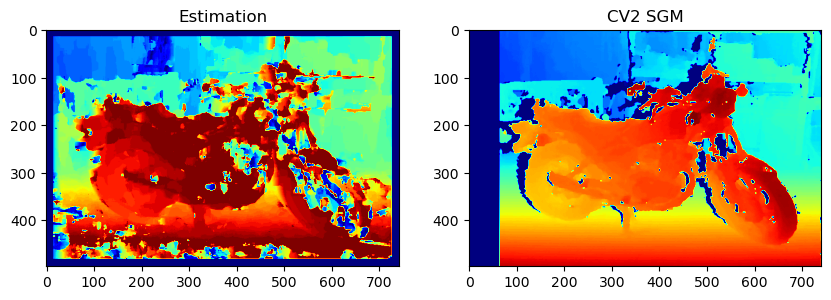

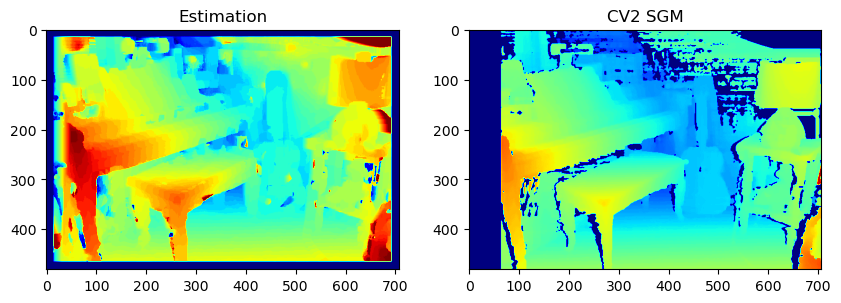

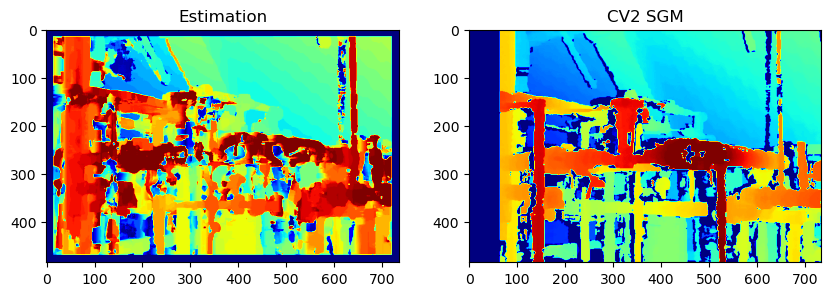

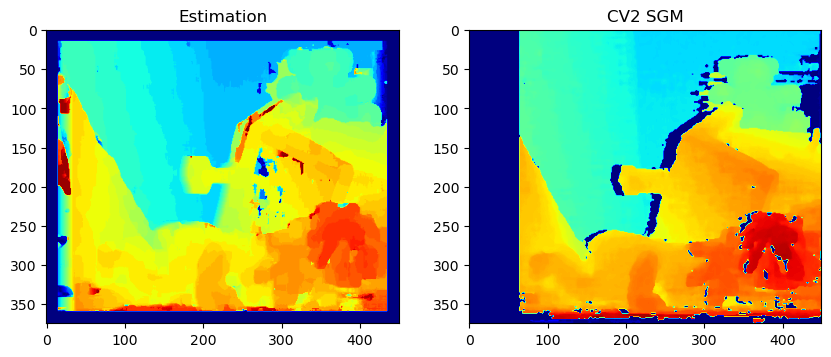

In [ ]:
for est, sgm in zip(disp_n, sgm_disp):
    fig, _ = dsiu.draw_2_img(est, sgm, "Estimation", "CV2 SGM", cmap="jet")

## WSL

In [ ]:
for i in range(2, 6):
    data = Data(i)

    # Create StereoSGBM object
    window_size = 5
    min_disp = -1
    num_disp = 16 * 4  # Must be divisible by 16

    stereo = cv2.StereoSGBM.create(
        minDisparity=min_disp,
        numDisparities=num_disp,
        blockSize=window_size,
        P1=8 * 3 * window_size ** 2,
        P2=32 * 3 * window_size ** 2,
        disp12MaxDiff=1,
        uniquenessRatio=15,
        speckleWindowSize=50,
        speckleRange=2,
        preFilterCap=63,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )
    
    wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
    wls_filter.setLambda(lmbda)
    wls_filter.setSigmaColor(sigma)

    

< cv2.ximgproc.DisparityWLSFilter 000001B8B98F5010>

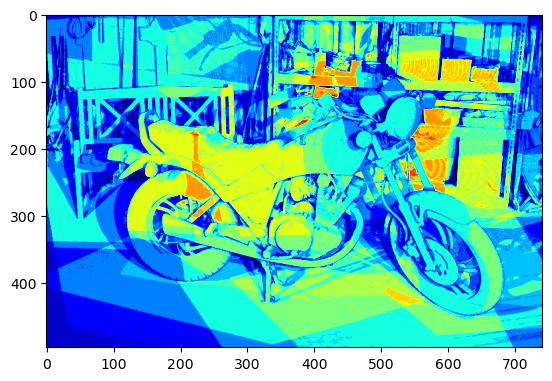

In [ ]:
a = cv2.imread(r"D:\code\py_steoreo_depth_estimation\datasets\disp2-n.pgm", cv2.IMREAD_GRAYSCALE)
a = cv2.normalize(a, None, 0, 255, cv2.NORM_MINMAX)
a = cv2.resize(a, Data(2).img1.shape[::-1][1:])
plt.imshow(a, cmap="jet")

In [ ]:
l2(a, disp_n[0])

93.92027468454451